In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from tqdm import tqdm

random.seed(2022)
np.random.seed(2022)
plt.style.use("ggplot")


In [2]:
class DataLoader:
    def __init__(self, X, y, batch_size, shuffle=True):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32)
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        size = self.y.shape[0]
        size_batch = size // self.batch_size
        if size_batch <= 0:
            return 1
        return size_batch

    def __getitem__(self, i):
        i_start = i * self.batch_size
        i_end = (i + 1) * self.batch_size
        X_batch = self.X[i_start:i_end]
        y_batch = self.y[i_start:i_end]
        if y_batch.shape[0] <= 0:
            if self.shuffle:
                idx = np.arange(self.y.shape[0])
                permutation = np.random.permutation(idx)
                self.X = self.X[idx]
                self.y = self.y[idx]
            raise IndexError("End of item")
        return X_batch, y_batch


In [3]:
data = load_diabetes()
X, y = data["data"], data["target"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

X_min, X_max = np.min(X_train, 0), np.max(X_train, 0)

X_train = (X_train - X_min) / (X_max - X_min)
X_valid = (X_valid - X_min) / (X_max - X_min)

# Dataloader hyperparameters
batch_size = 32
shuffle = True

# Dataloader
dataloader_train = DataLoader(X_train, y_train, batch_size, shuffle)
dataloader_valid = DataLoader(X_valid, y_valid, batch_size, not shuffle)


In [4]:
# Training hyperparameters
epoch = 50
lr = 1e-4
weight_decay = 1e-5

# Model
W1 = np.random.lognormal(size=(X.shape[-1], 32)).astype(np.float32) * 1e-2
b1 = np.random.lognormal(size=(32,)).astype(np.float32) * 1e-2

W2 = np.random.lognormal(size=(32, 64)).astype(np.float32) * 1e-2
b2 = np.random.lognormal(size=(64,)).astype(np.float32) * 1e-2

W3 = np.random.lognormal(size=(64, 1)).astype(np.float32) * 1e-2
b3 = np.random.lognormal(size=(1)).astype(np.float32) * 1e-2


In [5]:
record = []
for i in range(1, epoch + 1):

    print(f"Epoch {i}/{epoch}")
    pbar = tqdm(total=len(dataloader_train))

    loss_train = []
    for x_train, y_train in dataloader_train:
        # Forward pass
        bmm1 = np.einsum("bi,io->bo", x_train, W1)
        add1 = bmm1 + b1

        bmm2 = np.einsum("bi,io->bo", add1, W2)
        add2 = bmm2 + b2

        bmm3 = np.einsum("bi,io->bo", add2, W3)
        add3 = bmm3 + b3

        # Calculate loss (MSE)
        diff = add3 - y_train[:, None]
        loss = np.mean(np.square(diff)) / 2

        # Backward pass
        size = x_train.shape[0]
        out3_grad = diff / size

        b3_grad = np.einsum("o,bo->o", np.ones_like(b3), out3_grad)
        W3_grad = np.einsum("bi,bo->io", bmm2, out3_grad)

        out2_grad = np.einsum("io,bo->bi", W3, out3_grad)

        b2_grad = np.einsum("o,bo->o", np.ones_like(b2), out2_grad)
        W2_grad = np.einsum("bi,bo->io", bmm1, out2_grad)

        out1_grad = np.einsum("io,bo->bi", W2, out2_grad)

        b1_grad = np.einsum("o,bo->o", np.ones_like(b1), out1_grad)
        W1_grad = np.einsum("bi,bo->io", x_train, out1_grad)

        # Optimize (SGD with regularization)

        # Regularize
        b3_grad += b3 * weight_decay
        W3_grad += W3 * weight_decay

        b2_grad += b2 * weight_decay
        W2_grad += W2 * weight_decay

        b1_grad += b1 * weight_decay
        W1_grad += W1 * weight_decay

        # Update parameters
        b3 -= lr * b3_grad
        W3 -= lr * W3_grad

        b2 -= lr * b2_grad
        W2 -= lr * W2_grad

        b1 -= lr * b1_grad
        W1 -= lr * W1_grad

        # Record batch-wise loss
        loss_train.append(loss)
        pbar.update(1)
        pbar.set_postfix(loss=f"{np.mean(loss_train):.4f}")

    loss_train = np.mean(loss_train)
    record.append({"Epoch": i, "Subset": "Training", "Loss": loss_train})

    loss_valid = []
    for x_valid, y_valid in dataloader_valid:
        # Forward pass
        bmm1 = np.einsum("bi,io->bo", x_valid, W1)
        add1 = bmm1 + b1

        bmm2 = np.einsum("bi,io->bo", add1, W2)
        add2 = bmm2 + b2

        bmm3 = np.einsum("bi,io->bo", add2, W3)
        add3 = bmm3 + b3

        # Calculate loss (MSE)
        diff = add3 - y_valid[:, None]
        loss = np.mean(np.square(diff)) / 2

        # Record batch-wise loss
        loss_valid.append(loss)
        pbar.set_postfix(
            loss=f"{loss_train:.4f}", val_loss=f"{np.mean(loss_valid):.4f}"
        )

    loss_valid = np.mean(loss_valid)
    record.append({"Epoch": i, "Subset": "Validation", "Loss": loss_valid})

    # Add loss to progress bar
    pbar.close()


Epoch 1/50


12it [00:00, 999.14it/s, loss=13745.2320, val_loss=14586.5192]    


Epoch 2/50


12it [00:00, 1042.65it/s, loss=13710.7290, val_loss=14548.6019]   


Epoch 3/50


12it [00:00, 999.14it/s, loss=13671.4133, val_loss=14503.7428]    


Epoch 4/50


12it [00:00, 922.26it/s, loss=13623.0907, val_loss=14445.6872]    


Epoch 5/50


12it [00:00, 922.30it/s, loss=13557.0851, val_loss=14360.6979]    


Epoch 6/50


12it [00:00, 856.43it/s, loss=13452.9000, val_loss=14213.8792]   


Epoch 7/50


12it [00:00, 888.18it/s, loss=13253.0485, val_loss=13897.6637]    


Epoch 8/50


12it [00:00, 999.18it/s, loss=12754.0999, val_loss=12983.0632]    


Epoch 9/50


12it [00:00, 999.18it/s, loss=11020.6836, val_loss=9382.7910]     


Epoch 10/50


12it [00:00, 959.19it/s, loss=5520.7275, val_loss=2830.8102]     


Epoch 11/50


12it [00:00, 1042.54it/s, loss=2300.9122, val_loss=2381.6725]    


Epoch 12/50


12it [00:00, 959.19it/s, loss=2189.7388, val_loss=2326.4030]     


Epoch 13/50


12it [00:00, 959.19it/s, loss=2141.8142, val_loss=2277.1230]     


Epoch 14/50


12it [00:00, 1042.60it/s, loss=2097.4029, val_loss=2231.1279]    


Epoch 15/50


12it [00:00, 1042.60it/s, loss=2055.9834, val_loss=2187.8116]    


Epoch 16/50


12it [00:00, 888.12it/s, loss=2017.1333, val_loss=2146.7205]     


Epoch 17/50


12it [00:00, 959.21it/s, loss=1980.5205, val_loss=2107.5042]     


Epoch 18/50


12it [00:00, 1042.56it/s, loss=1945.8823, val_loss=2069.8916]    


Epoch 19/50


12it [00:00, 959.21it/s, loss=1913.0089, val_loss=2033.6775]     


Epoch 20/50


12it [00:00, 922.33it/s, loss=1881.7321, val_loss=1998.7102]     


Epoch 21/50


12it [00:00, 999.10it/s, loss=1851.9164, val_loss=1964.8834]     


Epoch 22/50


12it [00:00, 959.19it/s, loss=1823.4531, val_loss=1932.1302]     


Epoch 23/50


12it [00:00, 888.14it/s, loss=1796.2552, val_loss=1900.4163]     


Epoch 24/50


12it [00:00, 959.17it/s, loss=1770.2542, val_loss=1869.7367]     


Epoch 25/50


12it [00:00, 1042.49it/s, loss=1745.3973, val_loss=1840.1091]    


Epoch 26/50


12it [00:00, 888.04it/s, loss=1721.6450, val_loss=1811.5712]    


Epoch 27/50


12it [00:00, 959.17it/s, loss=1698.9691, val_loss=1784.1744]     


Epoch 28/50


12it [00:00, 922.30it/s, loss=1677.3500, val_loss=1757.9790]     


Epoch 29/50


12it [00:00, 888.12it/s, loss=1656.7757, val_loss=1733.0515]     


Epoch 30/50


12it [00:00, 888.17it/s, loss=1637.2390, val_loss=1709.4558]    


Epoch 31/50


12it [00:00, 888.12it/s, loss=1618.7354, val_loss=1687.2512]     


Epoch 32/50


12it [00:00, 999.22it/s, loss=1601.2609, val_loss=1666.4879]     


Epoch 33/50


12it [00:00, 959.06it/s, loss=1584.8100, val_loss=1647.2019]     


Epoch 34/50


12it [00:00, 1089.90it/s, loss=1569.3737, val_loss=1629.4135]    


Epoch 35/50


12it [00:00, 1141.72it/s, loss=1554.9382, val_loss=1613.1249]    


Epoch 36/50


12it [00:00, 922.31it/s, loss=1541.4836, val_loss=1598.3192]     


Epoch 37/50


12it [00:00, 1042.56it/s, loss=1528.9839, val_loss=1584.9612]    


Epoch 38/50


12it [00:00, 959.21it/s, loss=1517.4060, val_loss=1572.9985]     


Epoch 39/50


12it [00:00, 1042.56it/s, loss=1506.7114, val_loss=1562.3634]    


Epoch 40/50


12it [00:00, 1042.58it/s, loss=1496.8560, val_loss=1552.9763]    


Epoch 41/50


12it [00:00, 959.17it/s, loss=1487.7918, val_loss=1544.7480]     


Epoch 42/50


12it [00:00, 922.31it/s, loss=1479.4681, val_loss=1537.5839]     


Epoch 43/50


12it [00:00, 1198.91it/s, loss=1471.8328, val_loss=1531.3861]    


Epoch 44/50


12it [00:00, 1089.97it/s, loss=1464.8336, val_loss=1526.0575]    


Epoch 45/50


12it [00:00, 959.15it/s, loss=1458.4195, val_loss=1521.5025]     


Epoch 46/50


12it [00:00, 959.08it/s, loss=1452.5412, val_loss=1517.6313]     


Epoch 47/50


12it [00:00, 999.14it/s, loss=1447.1521, val_loss=1514.3588]     


Epoch 48/50


12it [00:00, 1042.69it/s, loss=1442.2087, val_loss=1511.6075]    


Epoch 49/50


12it [00:00, 1089.93it/s, loss=1437.6712, val_loss=1509.3068]    


Epoch 50/50


12it [00:00, 888.14it/s, loss=1433.5027, val_loss=1507.3936]     


<AxesSubplot:xlabel='Epoch', ylabel='Loss'>

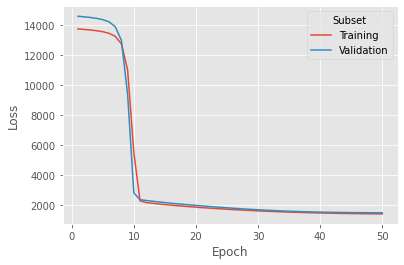

In [6]:
if not isinstance(record, pd.DataFrame):
    record = pd.DataFrame(record)
sns.lineplot(data=record, x="Epoch", y="Loss", hue="Subset")
